In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sastrawi
!pip install tensorflow
!pip install keras
!pip install pandas scikit-learn
!pip install nltk
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.optimizers import RMSprop, Adam
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Crawling Komentar Youtube**

In [ ]:
def video_comments(video_id):

	replies = []
	youtube = build('youtube', 'v3', developerKey=api_key)
	video_response = youtube.commentThreads().list(part='snippet,replies', videoId=video_id).execute()
	while video_response:
		for item in video_response['items']:

			date = item['snippet']['topLevelComment']['snippet']['publishedAt']
			name = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
			comment = item['snippet']['topLevelComment']['snippet']['textDisplay']

			replies.append([date, name, comment])

		if 'nextPageToken' in video_response:
			video_response = youtube.commentThreads().list(
					part = 'snippet,replies',
					pageToken = video_response['nextPageToken'],
					videoId = video_id
				).execute()
		else:
			break
	return replies


In [ ]:
api_key = 'Isi API KEY'
video_id = "Isi Video ID"
comment = video_comments(video_id)

comment

[['2023-01-24T10:20:43Z',
  'VIVA.CO.ID',
  'Berita Terkait:<br>Rektor Unhas Sebut IKN Harga Mati bagi Indonesia Timur - <a href="http://bit.ly/3DcgE98">http://bit.ly/3DcgE98</a>'],
 ['2023-03-05T12:51:37Z',
  'EKO',
  '@Karis Riadi TERIMA KASIH PAK ANIES BASWEDAN<br>LANJUT JADI PRESIDEN RI TAHUN 2024 YAA..<br>SEBARKAAN...!!!!!!!!!!'],
 ['2023-03-05T09:06:18Z', 'Karis Riadi', '@EKO masih waraskah anda...<br>?'],
 ['2023-02-26T01:25:56Z',
  'Alexander 21mntab',
  '@Dwiwarna kalau Ahox yang maju lo dukung ya'],
 ['2023-02-19T01:26:42Z',
  'EKO',
  'TERIMA KASIH PAK ANIES BASWEDAN<br>LANJUT JADI PRESIDEN RI TAHUN 2024 YAA..<br>SEBARKAAN...!!!!!!!!!!'],
 ['2023-02-19T01:26:37Z',
  'EKO',
  'TERIMA KASIH PAK ANIES BASWEDAN<br>LANJUT JADI PRESIDEN RI TAHUN 2024 YAA..<br>SEBARKAAN...!!!!!!!!!!'],
 ['2023-03-29T11:14:57Z',
  'Arm Betta',
  'Jangan lupa Utamakan keselamatan kesehatan kerja, semoga teman teman pekerja semua sehat dan bahagia'],
 ['2023-03-25T02:23:13Z',
  'Zaki Rahman Fitriansya

In [ ]:
df = pd.DataFrame(comment, columns=['publishedAt', 'authorDisplayName', 'textDisplay'])
df

,publishedAt,authorDisplayName,textDisplay
0,2023-01-24T10:20:43Z,VIVA.CO.ID,Berita Terkait:<br>Rektor Unhas Sebut IKN Harg...
1,2023-03-05T12:51:37Z,EKO,@Karis Riadi TERIMA KASIH PAK ANIES BASWEDAN<b...
2,2023-03-05T09:06:18Z,Karis Riadi,@EKO masih waraskah anda...<br>?
3,2023-02-26T01:25:56Z,Alexander 21mntab,@Dwiwarna kalau Ahox yang maju lo dukung ya
4,2023-02-19T01:26:42Z,EKO,TERIMA KASIH PAK ANIES BASWEDAN<br>LANJUT JADI...
...,...,...,...
2151,2023-02-02T12:31:33Z,semelekete,@Kopi pahit ini Jokowi si jawa yg Lo ngemis2 p...
2152,2023-01-27T14:43:42Z,Fer,Sorry ini era jokowi bukan presiden yang dulu...
2153,2023-01-24T23:05:20Z,Rafa Rahman,@Nabil Choiri lah emang yang maha kuasa kan di...
2154,2023-01-24T17:47:24Z,Nabil Choiri,@Rafa Rahman yg pengang UU itu DPR dan MPR kw...


In [ ]:
df.to_csv('comment.csv', index=False)

### **View** **Data** **Labeling**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/File_Skripsi/comment.csv')
data = data[['Komentar','Polarity']]

In [ ]:
data.head()

,Komentar,Polarity
0,Berita Terkait:<br>Rektor Unhas Sebut IKN Harg...,Positif
1,@Karis Riadi TERIMA KASIH PAK ANIES BASWEDAN<b...,Netral
2,@EKO masih waraskah anda...<br>?,Netral
3,@Dwiwarna kalau Ahox yang maju lo dukung ya,Netral
4,TERIMA KASIH PAK ANIES BASWEDAN<br>LANJUT JADI...,Netral


### **Pre**-**Processing** **Teks**

In [ ]:
def casefolding(text):

    # lower text
    text = text.lower()

    return text

def clean_text(text):

    # hapus mention
    text = ' '.join(re.sub('([@#]+[A-Za-z0-9]+)|([@_#]+[A-Za-z0-9]+)|(\w+:\/\/\S+)',' ', text).split())

    # hapus hastag/#tagger
    text = re.sub(r'#([^\s]+)', ' ', text)

    # hapus html
    text = re.sub(r'http\S+', ' ', text)

    #menghapus tag <br>
    text = re.sub(r'<.*?>', ' ', text)

    # hapus ASCII dan unicode
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^\x00-\x7f]',r' ', text)

    # hapus angka
    text = re.sub(r'\d+', ' ', text)

    # hapus single char
    text = re.sub(r'\b[a-zA-Z]\b', ' ', text)
    text = re.sub(r'\.', ' ', text)

    # hapus remove tab, new line, dan back slice
    text = text.replace('\\t',' ').replace('\\n',' ').replace('\\u',' ').replace('\\',' ').replace('href', ' ').replace('&amp', ' ').replace('&quot', ' ').replace(',', ' ')

    # hapus punctuation/tanda baca
    text = text.translate(str.maketrans(' ',' ', string.punctuation))

    return text

def tokenizingText(text):
    # memisahkan teks menjadi token
    text = word_tokenize(text)

    return text

def stopword(text):
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()

    return [stopword_remover.remove(word) for word in text]

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text



In [ ]:
data['casefolding'] = data['Komentar'].apply(casefolding)
data['cleaned_text'] = data['casefolding'].apply(clean_text)
data.to_csv('cleaned_dataa.csv', index=True)

In [ ]:
def normalize_text(text, abbreviation_dict):
    words = text.split()  # Memisahkan teks menjadi kata-kata

    normalized_words = []  # Untuk menyimpan kata-kata hasil normalisasi

    for word in words:
        # Menggunakan kata lengkap dari kamus jika kata adalah singkatan
        if word in abbreviation_dict:
            normalized_words.append(abbreviation_dict[word])
        else:
            normalized_words.append(word)  # Menambahkan kata asli jika bukan singkatan

    normalized_text = ' '.join(normalized_words)  # Menggabungkan kata-kata menjadi teks kembali
    return normalized_text

# Membaca kamus singkatan dari file CSV
abbreviation_df = pd.read_csv('/content/drive/MyDrive/File_Skripsi/singkatan.csv')
abbreviation_dict = dict(zip(abbreviation_df['Singkatan'], abbreviation_df['Ekspansi']))

# Membaca teks-teks hasil pembersihan dari file CSV
cleaned_df = pd.read_csv('/content/drive/MyDrive/File_Skripsi/data_cleaned.csv')

# Iterasi melalui setiap baris di DataFrame
for index, row in cleaned_df.iterrows():
    cleaned_text = row['cleaned_text']

    if isinstance(cleaned_text, str):
        normalized_text = normalize_text(cleaned_text, abbreviation_dict)
        cleaned_df.at[index, 'normalized_text'] = normalized_text
    else:
        cleaned_df.at[index, 'normalized_text'] = cleaned_text

cleaned_df.to_csv('normalized_data.csv', index=True)


In [ ]:
cleaned_df['tokenizing'] = cleaned_df['normalized_text'].apply(lambda x: tokenizingText(x) if isinstance(x, str) else [])
cleaned_df['stopword'] = cleaned_df['tokenizing'].apply(lambda x: stopword(x) if isinstance(x, list) else [])
cleaned_df['stemming'] = cleaned_df['stopword'].apply(lambda x: stemmingText(x) if isinstance(x, list) else [])
cleaned_df['text_preprocessed'] = cleaned_df['stemming'].apply(lambda x: [word for word in x if word != ''])

In [ ]:
cleaned_df

,Unnamed: 0,Komentar,Polarity,casefolding,cleaned_text,normalized_text,tokenizing,stopword,stemming,text_preprocessed
0,0,Berita Terkait:<br>Rektor Unhas Sebut IKN Harg...,Positif,berita terkait:<br>rektor unhas sebut ikn harg...,berita terkait rektor unhas sebut ikn harga ma...,berita terkait rektor unhas sebut ikn harga ma...,"[berita, terkait, rektor, unhas, sebut, ikn, h...","[berita, terkait, rektor, unhas, sebut, ikn, h...","[berita, kait, rektor, unhas, sebut, ikn, harg...","[berita, kait, rektor, unhas, sebut, ikn, harg..."
1,1,@Karis Riadi TERIMA KASIH PAK ANIES BASWEDAN<b...,Netral,@karis riadi terima kasih pak anies baswedan<b...,riadi terima kasih pak anies baswedan lanjut j...,riadi terima kasih bapak anies baswedan baswed...,"[riadi, terima, kasih, bapak, anies, baswedan,...","[riadi, terima, kasih, bapak, anies, baswedan,...","[riadi, terima, kasih, bapak, anies, baswedan,...","[riadi, terima, kasih, bapak, anies, baswedan,..."
2,2,@EKO masih waraskah anda...<br>?,Netral,@eko masih waraskah anda...<br>?,masih waraskah anda,masih waraskah anda,"[masih, waraskah, anda]","[, waraskah, ]","[, waras, ]",[waras]
3,3,@Dwiwarna kalau Ahox yang maju lo dukung ya,Netral,@dwiwarna kalau ahox yang maju lo dukung ya,kalau ahox yang maju lo dukung ya,kalau ahox yang maju anda dukung iya,"[kalau, ahox, yang, maju, anda, dukung, iya]","[kalau, ahox, , maju, , dukung, iya]","[kalau, ahox, , maju, , dukung, iya]","[kalau, ahox, maju, dukung, iya]"
4,6,Pindah Papua aja biar di Papua berkembang :),Negatif,pindah papua aja biar di papua berkembang :),pindah papua aja biar di papua berkembang,pindah papua saja biar di papua berkembang,"[pindah, papua, saja, biar, di, papua, berkemb...","[pindah, papua, , biar, , papua, berkembang]","[pindah, papua, , biar, , papua, kembang]","[pindah, papua, biar, papua, kembang]"
...,...,...,...,...,...,...,...,...,...,...
2002,2149,@Kopi pahit ini Jokowi si jawa yg Lo ngemis2 p...,Negatif,@kopi pahit ini jokowi si jawa yg lo ngemis2 p...,pahit ini jokowi si jawa yg lo ngemis pusat m...,pahit ini jokowi si jawa yang anda mengemis pu...,"[pahit, ini, jokowi, si, jawa, yang, anda, men...","[pahit, , jokowi, si, jawa, , , mengemis, pusa...","[pahit, , jokowi, si, jawa, , , emis, pusat, m...","[pahit, jokowi, si, jawa, emis, pusat, minta, ..."
2003,2150,Sorry ini era jokowi bukan presiden yang dulu...,Netral,sorry ini era jokowi bukan presiden yang dulu...,sorry ini era jokowi bukan presiden yang dulu,sorry ini era jokowi bukan presiden yang dulu,"[sorry, ini, era, jokowi, bukan, presiden, yan...","[sorry, , era, jokowi, bukan, presiden, , dulu]","[sorry, , era, jokowi, bukan, presiden, , dulu]","[sorry, era, jokowi, bukan, presiden, dulu]"
2004,2151,@Nabil Choiri lah emang yang maha kuasa kan di...,Negatif,@nabil choiri lah emang yang maha kuasa kan di...,choiri lah emang yang maha kuasa kan di indone...,choiri lah memang yang maha kuasa kan di indon...,"[choiri, lah, memang, yang, maha, kuasa, kan, ...","[choiri, lah, memang, , maha, kuasa, kan, , in...","[choiri, lah, memang, , maha, kuasa, kan, , in...","[choiri, lah, memang, maha, kuasa, kan, indone..."
2005,2152,@Rafa Rahman yg pengang UU itu DPR dan MPR kw...,Netral,@rafa rahman yg pengang uu itu dpr dan mpr kw...,rahman yg pengang uu itu dpr dan mpr kwkwkw dongo,rahman yang pegang undang undang itu dpr dan m...,"[rahman, yang, pegang, undang, undang, itu, dp...","[rahman, , pegang, undang, undang, , dpr, , mp...","[rahman, , pegang, undang, undang, , dpr, , mp...","[rahman, pegang, undang, undang, dpr, mpr, kwk..."


In [ ]:
cleaned_df.to_csv('txtpreprocessed.csv', index=True)

## Split Data, TF-IDF, dan SMOTE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

# Pembagian data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['text_preprocessed'], cleaned_df['Polarity'], test_size=0.2, random_state=42)

# mengubah token kata menjadi string kembali
X_strings = [" ".join(tokens) for tokens in X_train]
X_test_strings = [" ".join(tokens) for tokens in X_test]

# Menerapkan TF-IDF vectorizer pada seluruh data
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_strings)
X_test_tfidf = tfidf_vectorizer.transform(X_test_strings)

# Menerapkan SMOTE untuk oversampling pada X_train_tfidf
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Menggabungkan kembali hasil TF-IDF ke dalam format teks
X_train_resampled_texts = [' '.join(tfidf_vectorizer.inverse_transform(csr_matrix(row))[0]) for row in X_train_resampled]
X_test_texts = [' '.join(tfidf_vectorizer.inverse_transform(csr_matrix(row))[0]) for row in X_test_tfidf]

# Inisialisasi objek Tokenizer
tokenizer = Tokenizer()

# Proses dan konversi teks ke indeks
tokenizer.fit_on_texts(X_train_resampled_texts)

# Tentukan jumlah kata maksimum yang akan diikutsertakan
num_words = len(tokenizer.word_index) + 1

# Inisialisasi Tokenizer untuk LSTM
tokenizer= Tokenizer(num_words=num_words)

# Proses dan konversi teks ke indeks
tokenizer.fit_on_texts(X_train_resampled_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_resampled_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Padding data sekuensial
max_sequence_length = 300
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Mengganti label teks dengan bilangan bulat
label_mapping = {'Positif': 2, 'Negatif': 0, 'Netral': 1}
y_train_encoded = y_train_resampled.map(label_mapping)
y_test_encoded = y_test.map(label_mapping)

# Ubah label menjadi one-hot encoding
y_train_encoded = to_categorical(y_train_encoded, num_classes=3)
y_test_encoded = to_categorical(y_test_encoded, num_classes=3)


In [ ]:
X_train.to_csv('train.csv', index=False)

In [ ]:
X_test.to_csv('test.csv', index=False)

In [ ]:
from google.colab import files
files.download('train.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
count= CountVectorizer(max_features=2000)
X = count.fit_transform(X_strings)
# Matriks Term Frequency
df_term_frequency = pd.DataFrame(X.toarray(), columns=count.get_feature_names_out())
df_term_frequency.fillna(0, inplace=True)
df_term_frequency.to_csv('count.csv', index=False)
df_term_frequency.to_excel('count.xlsx', index=False)
print("Term Frequency Table:")
print(df_term_frequency)


Term Frequency Table:
      aalamiin  aamiin  abad  abai  abal  abud  ada  adab  adat  adil  ...  \
0            0       0     0     0     0     0    0     0     0     0  ...   
1            0       0     0     0     0     0    0     0     0     0  ...   
2            0       0     0     0     0     0    0     0     0     0  ...   
3            0       0     0     0     0     0    0     0     0     0  ...   
4            0       0     0     0     0     0    0     0     0     0  ...   
...        ...     ...   ...   ...   ...   ...  ...   ...   ...   ...  ...   
1600         0       0     0     0     0     0    0     0     0     0  ...   
1601         0       0     0     0     0     0    0     0     0     0  ...   
1602         0       0     0     0     0     0    0     0     0     0  ...   
1603         0       0     0     0     0     0    0     0     0     0  ...   
1604         0       0     0     0     0     0    0     0     0     0  ...   

      yohanies  yoi  york  you  youtuber 

In [ ]:
# Matriks TF-IDF
df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf.fillna(0, inplace=True)
df_tfidf.to_csv('tfidf_tes.csv', index=False)
print("\nTF-IDF Table:")
print(df_tfidf)


TF-IDF Table:
      aalamiin  aamiin  abad  abai  abal  abud  ada  adab  adat  adil  ...  \
0          0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
1          0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
2          0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
3          0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
4          0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
...        ...     ...   ...   ...   ...   ...  ...   ...   ...   ...  ...   
1600       0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
1601       0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
1602       0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
1603       0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   
1604       0.0     0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  ...   

      yohanies  yoi  york  you  youtuber  yra  y

In [ ]:
# Mengambil nilai-nilai TF-IDF tertinggi untuk setiap kata
nilai_tertinggi = pd.DataFrame({'feature_name':count.get_feature_names_out(), 'TF-IDF':df_tfidf.max()})
print("Kata-kata dengan Nilai TF-IDF Tertinggi:")
# Menambahkan indeks
nilai_tertinggi.reset_index(drop=True, inplace=True)
# Mengurutkan DataFrame berdasarkan kolom 'TF-IDF' secara menurun
nilai_tertinggi_sorted = nilai_tertinggi.sort_values(by='TF-IDF', ascending=False)
# Menampilkan DataFrame yang sudah diurutkan
print(nilai_tertinggi_sorted)
nilai_tertinggi_sorted.to_csv('nilai_tertinggi.csv', index=True)


Kata-kata dengan Nilai TF-IDF Tertinggi:
     feature_name    TF-IDF
1601  subhanallah  1.000000
263          cina  1.000000
1520          sia  1.000000
582       kampung  1.000000
630         kerja  1.000000
...           ...       ...
1712        tebar  0.068537
967          pada  0.068537
1823        total  0.068537
1367      samping  0.068537
1953      waspada  0.068537

[2000 rows x 2 columns]


In [ ]:
df_tfidf.to_excel('tfidf.xlsx', index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
idf = pd.DataFrame({'feature_name':count.get_feature_names_out(), 'idf_weights':tfidf_transformer.idf_})
print(idf)
idf.to_csv('idf_values.csv', index=False)

     feature_name  idf_weights
0        aalamiin     7.688355
1          aamiin     4.091042
2            abad     6.995208
3            abai     7.282890
4            abal     7.282890
...           ...          ...
1995          yra     6.589742
1996          ytc     7.688355
1997        zaman     6.589742
1998         zona     7.688355
1999         zonk     7.688355

[2000 rows x 2 columns]


In [ ]:
idf.to_excel('idf_values.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('idf_values.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('tfidf.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('count.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

# Membuat DataFrame dari data latih (X_strings) dan label kelas (y_train)
train_df = pd.DataFrame({'Text': X_strings, 'Label': y_train})

# Tampilkan tabel
print(train_df)

train_df.to_csv('training.csv', index=False)
files.download('training.csv')


                                                   Text    Label
916    tetangga bangun rumah lantai hutang warung lunas   Netral
261                       ikn jadi hutang negara tumpuk  Negatif
607   satu minta kait ikn plizzzz jangan repro desai...  Positif
1331  art official bodoh kau ukur hutang tumpuk bung...  Negatif
240                                                sana   Netral
...                                                 ...      ...
1130                                                sia  Negatif
1294  ayo cepat selesai yakin geliat politik ekonomi...  Positif
860   proses bangun bangun sistem modular sangat pra...  Positif
1459                     ujung nya mangkrak kalau jabat  Negatif
1126              masak sih benar bohong korban deal an  Negatif

[1605 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Membuat DataFrame dari data latih (X_strings) dan label kelas (y_train)
test_df = pd.DataFrame({'Text': X_test_strings, 'Label': y_test})

# Tampilkan tabel
print(test_df)

test_df.to_csv('testing.csv', index=False)


                                                   Text    Label
1960               jantan kalau anies baswedan mangkrak  Negatif
526    moga uranium dikalimantan segera pindah tiongkok  Negatif
393   moga indonesia tambah maju rakyat nya dapat ke...  Positif
1402  sangat cepat bagus sekali moga semua tetap lan...  Positif
433   jadi gundul hutan proyek ambisius urgensi pind...  Negatif
...                                                 ...      ...
938                                      calon mangkrak  Negatif
1326  alhamdulillah moga ikan lancar bangun nya moga...  Positif
1138  agustus upacara hut ri gelar ikn bursa efek bu...   Netral
1037                  alhamdulillah moga lancar selamat  Positif
654   ini karya tata putraputri cerdik pandai iya tu...  Positif

[402 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('hasil_testing.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Menghitung jumlah masing-masing kelas sebelum SMOTE
class_counts_before = y_train.value_counts()
# Menghitung jumlah masing-masing kelas setelah SMOTE
class_counts_after = pd.Series(y_train_resampled).value_counts()

# Tampilkan jumlah kelas sebelum dan setelah SMOTE
print("Jumlah Kelas Sebelum SMOTE:")
print(class_counts_before)

print("\nJumlah Kelas Setelah SMOTE:")
print(class_counts_after)

Jumlah Kelas Sebelum SMOTE:
Positif    673
Negatif    522
Netral     410
Name: Polarity, dtype: int64

Jumlah Kelas Setelah SMOTE:
Netral     673
Negatif    673
Positif    673
Name: Polarity, dtype: int64


In [ ]:
# Membuat DataFrame dari teks hasil SMOTE
df_smote = pd.DataFrame({'text_preprocessed': X_train_resampled_texts, 'Polarity': y_train_resampled})

# Menampilkan 5 baris pertama dari DataFrame hasil SMOTE
print(df_smote)
df_smote.to_csv('hasil_smote.csv', index=False)

                                      text_preprocessed Polarity
0             lunas warung hutang rumah bangun tetangga   Netral
1                         tumpuk negara jadi ikn hutang  Negatif
2     soetta bandara terminal kasus macam kualitas d...  Positif
3     asing investor bisnis paham buruh utama hasil ...  Negatif
4                                                  sana   Netral
...                                                 ...      ...
2014    jadi negara dong maju mau fun tanya ada tunjang   Netral
2015  investor bukan apbn pernah baca berita asal ko...   Netral
2016                                  pintar video viva   Netral
2017     ikn jadi kalau presiden mudah benar suku paser   Netral
2018  bapak rakyat indonesia paling lah pikir bro bi...   Netral

[2019 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('hasil_smote.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install --upgrade keras


## Pemodelan Long Short-Term Memory (LSTM)

In [ ]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV

def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=200, input_length=max_sequence_length))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# paramater yang akan di tuning
hyperparameters = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64, 128],
    'epochs': [5, 10, 15]
}

# Buat objek GridSearchCV dan jalankan grid search dengan skor kustom
model = KerasClassifier(model=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='accuracy', cv=3)
grid_result = grid.fit(X_train_padded, y_train_encoded)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/5
43/43 [==============================] - 17s 233ms/step - loss: 1.0466 - accuracy: 0.4807
Epoch 2/5
43/43 [==============================] - 5s 118ms/step - loss: 0.8192 - accuracy: 0.6694
Epoch 3/5
43/43 [==============================] - 4s 83ms/step - loss: 0.5321 - accuracy: 0.8105
Epoch 4/5
43/43 [==============================] - 4s 87ms/step - loss: 0.3182 - accuracy: 0.8863
Epoch 5/5
22/22 [==============================] - 1s 8ms/step
Epoch 1/5
43/43 [==============================] - 7s 112ms/step - loss: 1.0467 - accuracy: 0.4673
Epoch 2/5
43/43 [==============================] - 6s 128ms/step - loss: 0.7867 - accuracy: 0.7110
Epoch 3/5
43/43 [==============================] - 4s 81ms/step - loss: 0.4863 - accuracy: 0.8217
Epoch 4/5
43/43 [==============================] - 2s 53ms/step - loss: 0.3646 - accuracy: 0.8648
Epoch 5/5
22/22 [==============================] - 0s 9ms/step
Epoch 1/5
43/43 [==============================] - 8s 152ms/step - loss: 1.0356 - acc

In [ ]:
model=create_model()
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 300, 200)          400200    
                                                                 
 lstm_55 (LSTM)              (None, 64)                67840     
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 3)                 195       
                                                                 
Total params: 468235 (1.79 MB)
Trainable params: 468235 (1.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
score = grid_result.score(X_test_padded, y_test_encoded)
print('Test accuracy:', score)

7/7 [==============================] - 1s 10ms/step
Test accuracy: 0.6467661691542289


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

y_pred_probs = grid_result.predict(X_test_padded)
y_pred_class = np.argmax(y_pred_probs, axis=1)
df_test = pd.DataFrame({'true': y_test_encoded.tolist(), 'pred':y_pred_class})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

7/7 [==============================] - 0s 10ms/step
confusion matrix [[ 81  23  26]
 [ 35  63  22]
 [ 13  23 116]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       130
           1       0.58      0.53      0.55       120
           2       0.71      0.76      0.73       152

    accuracy                           0.65       402
   macro avg       0.64      0.64      0.64       402
weighted avg       0.64      0.65      0.64       402



In [ ]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_result.cv_results_)
akurasi = cv_results_df[['param_batch_size', 'param_epochs', 'param_optimizer', 'mean_test_score']]

print(akurasi)

   param_batch_size param_epochs param_optimizer  mean_test_score
0                32            5            adam         0.742942
1                32            5         rmsprop         0.752848
2                32           10            adam         0.749381
3                32           10         rmsprop         0.756315
4                32           15            adam         0.738980
5                32           15         rmsprop         0.721149
6                64            5            adam         0.675582
7                64            5         rmsprop         0.723130
8                64           10            adam         0.744923
9                64           10         rmsprop         0.759287
10               64           15            adam         0.766221
11               64           15         rmsprop         0.752353
12              128            5            adam         0.635463
13              128            5         rmsprop         0.604755
14        

## Hasil Prediksi

In [ ]:
# Buat dictionary keterangan
keterangan = {2: 'Positif', 0: 'Negatif', 1: 'Netral'}

# Buat DataFrame dari hasil prediksi dan label aktual
df_comparison = pd.DataFrame({'Aktual': df_test['true'].map(keterangan), 'Prediksi': df_test['pred'].map(keterangan)})

# Tampilkan DataFrame dalam bentuk teks
print(df_comparison.to_string(index=False))

df_comparison.to_csv('hasil_prediksi_fix.csv', index=True)

 Aktual Prediksi
Negatif  Negatif
Negatif  Positif
Positif  Positif
Positif  Positif
Negatif  Positif
 Netral   Netral
 Netral   Netral
Positif  Positif
 Netral  Negatif
Positif   Netral
Positif   Netral
Positif  Positif
Positif  Positif
Negatif  Negatif
 Netral  Negatif
Positif   Netral
 Netral  Positif
 Netral   Netral
Negatif  Negatif
Negatif  Negatif
 Netral   Netral
 Netral  Negatif
Negatif  Positif
Positif  Positif
Positif   Netral
Positif  Positif
Negatif  Negatif
Positif  Positif
 Netral  Positif
 Netral   Netral
 Netral  Negatif
Positif  Positif
Negatif  Negatif
 Netral   Netral
 Netral   Netral
 Netral   Netral
Negatif  Negatif
Positif  Positif
 Netral   Netral
Negatif   Netral
Positif  Positif
 Netral   Netral
 Netral   Netral
Negatif  Negatif
Negatif  Negatif
 Netral  Negatif
Positif  Positif
Negatif  Positif
Positif  Positif
Negatif   Netral
 Netral   Netral
Positif  Positif
 Netral  Negatif
Positif  Positif
Positif  Positif
 Netral  Positif
Negatif  Negatif
Negatif  Posit

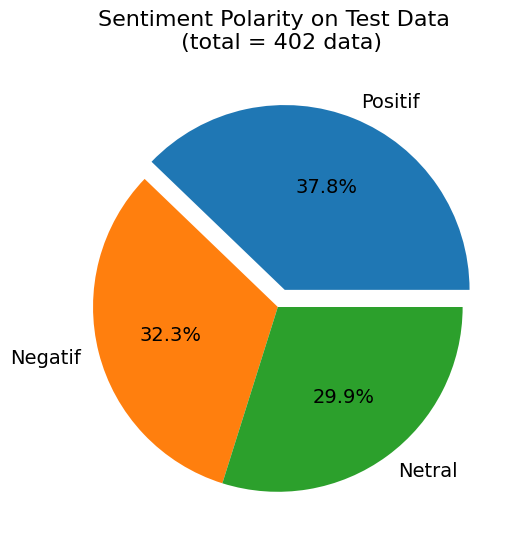

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengubah numpy array menjadi pandas Series
y_test_series = pd.Series(y_test)

# Menghitung distribusi sentimen pada data uji
sizes = [count for count in y_test_series.value_counts()]
labels = list(y_test_series.value_counts().index)
explode = (0.1, 0, 0)

# Membuat pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title(f'Sentiment Polarity on Test Data \n (total = {len(y_test_series)} data)', fontsize=16, pad=20)
plt.show()

## Confusion Matrix

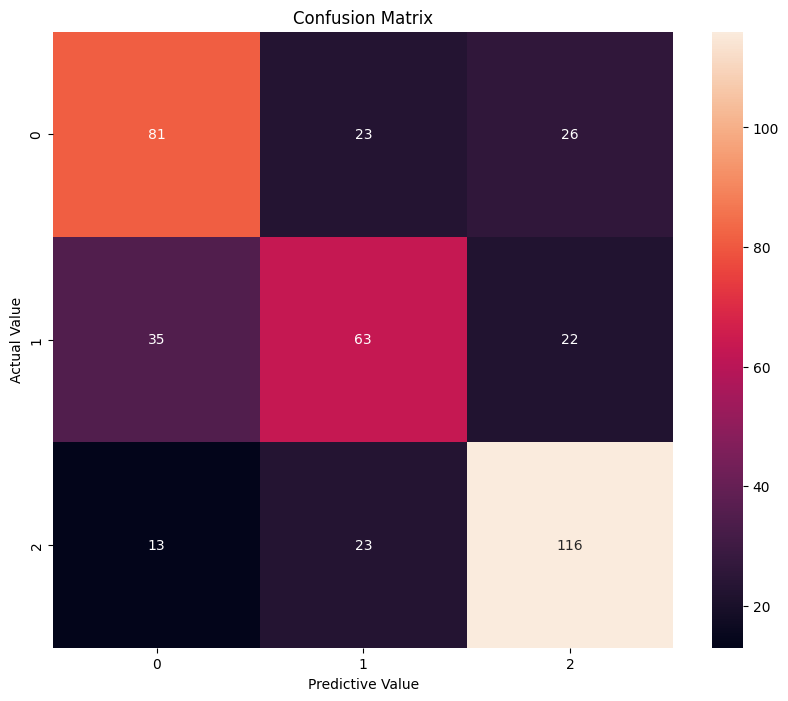

In [ ]:
# Import package
import seaborn as sns
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predictive Value")
plt.ylabel("Actual Value")
plt.show()

## Wordcloud

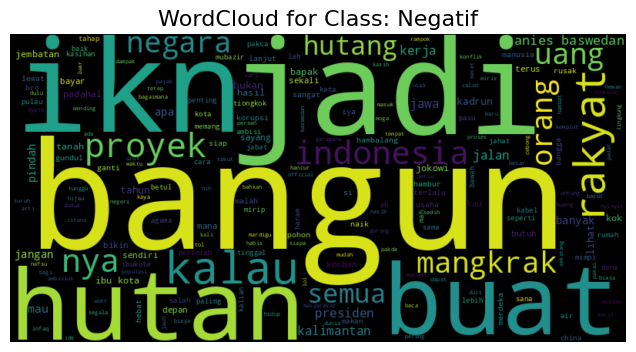

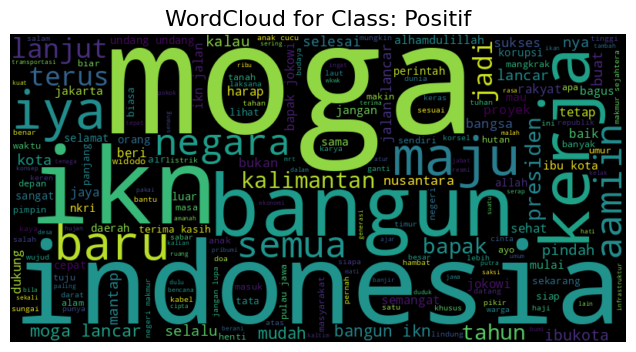

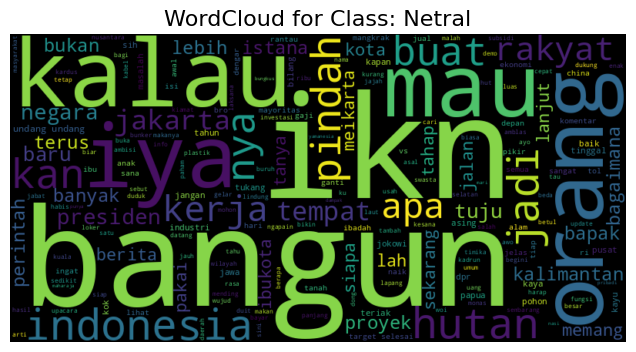

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Menggabungkan data uji dan label ke dalam DataFrame
df = pd.DataFrame({'Teks': X_test_strings, 'Kelas': y_test})

# Menginisialisasi dictionary untuk teks dalam setiap kelas
class_texts = {}

# Mengelompokkan teks berdasarkan kelas
for label in df['Kelas'].unique():
    texts_for_class = " ".join(df[df['Kelas'] == label]['Teks'])
    class_texts[label] = texts_for_class

# Membuat WordCloud untuk setiap kelas
for label, text in class_texts.items():
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for Class: {label}', fontsize=16)
    plt.axis('off')
    plt.show()
